In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

### Overview of Expontential Smoothing

Exponential smoothing models are a family of forecasting methods used in time series analysis. They are called "exponential" because they assign exponentially decreasing weights to past observations, meaning the most recent observations have more influence on the forecast than older observations. These models are popular due to their simplicity, efficiency, and flexibility. Here's a brief overview of the main types of exponential smoothing models:

1. Simple Exponential Smoothing (SES)
- Used when: The time series data does not display a trend or seasonal patterns.
- Key idea: Forecasts are calculated using the weighted average of past observations, with the weights decreasing exponentially as the observations get older.
- Formula component: The level of the series.
2. Holt’s Linear Trend Method
- Used when: The time series data shows a trend but no seasonal patterns.
- Key idea: This method extends SES by adding support for trends in the data. It introduces a second equation to capture the trend, alongside the level equation.
- Formula components: The level and trend of the series.
3. Holt-Winters Seasonal Method
- Also known as: Triple Exponential Smoothing.
- Used when: The time series data exhibits both trend and seasonal patterns.
- Key idea: This method adds a third equation to account for seasonality, in addition to the level and trend equations. It can handle both additive and multiplicative seasonality.
- Formula components: The level, trend, and seasonal component of the series.

*Key Concepts*
- Level: The average value in the series.
- Trend: The increasing or decreasing direction in the series over time.
- Seasonality: Patterns that repeat at regular intervals, like higher sales during the holiday season.

*Why Use Exponential Smoothing Models?*
- Simplicity: They are straightforward to understand and implement.
- Flexibility: They can be adapted to different types of time series data (with or without trends and seasonality).
- Efficiency: They require relatively little computation, making them suitable for large datasets or real-time analysis.

*Choosing the Right Model*
The choice among SES, Holt’s Linear Trend Method, and Holt-Winters Seasonal Method depends on the characteristics of your time series data. Examining the data for trends and seasonal patterns can help you select the most appropriate exponential smoothing model for your forecasting needs.

In [2]:
MtWashington_weather = pd.read_csv('MtWashingtonDailyTemps.csv', index_col='DATE', parse_dates=True)
MtWashington_weather.head()

,MinTemp,MaxTemp,AvgTemp,AvgWindSpeed,Sunrise,Sunset
DATE,,,,,,
2014-12-01,3,36,20,65.1,700,1608
2014-12-02,1,22,12,34.7,702,1607
2014-12-03,8,32,20,53.0,703,1607
2014-12-04,-5,9,2,60.2,704,1607
2014-12-05,6,17,12,30.5,705,1607


The weather data is aggregated by day. The following plot shows the minimum temperatures each day.

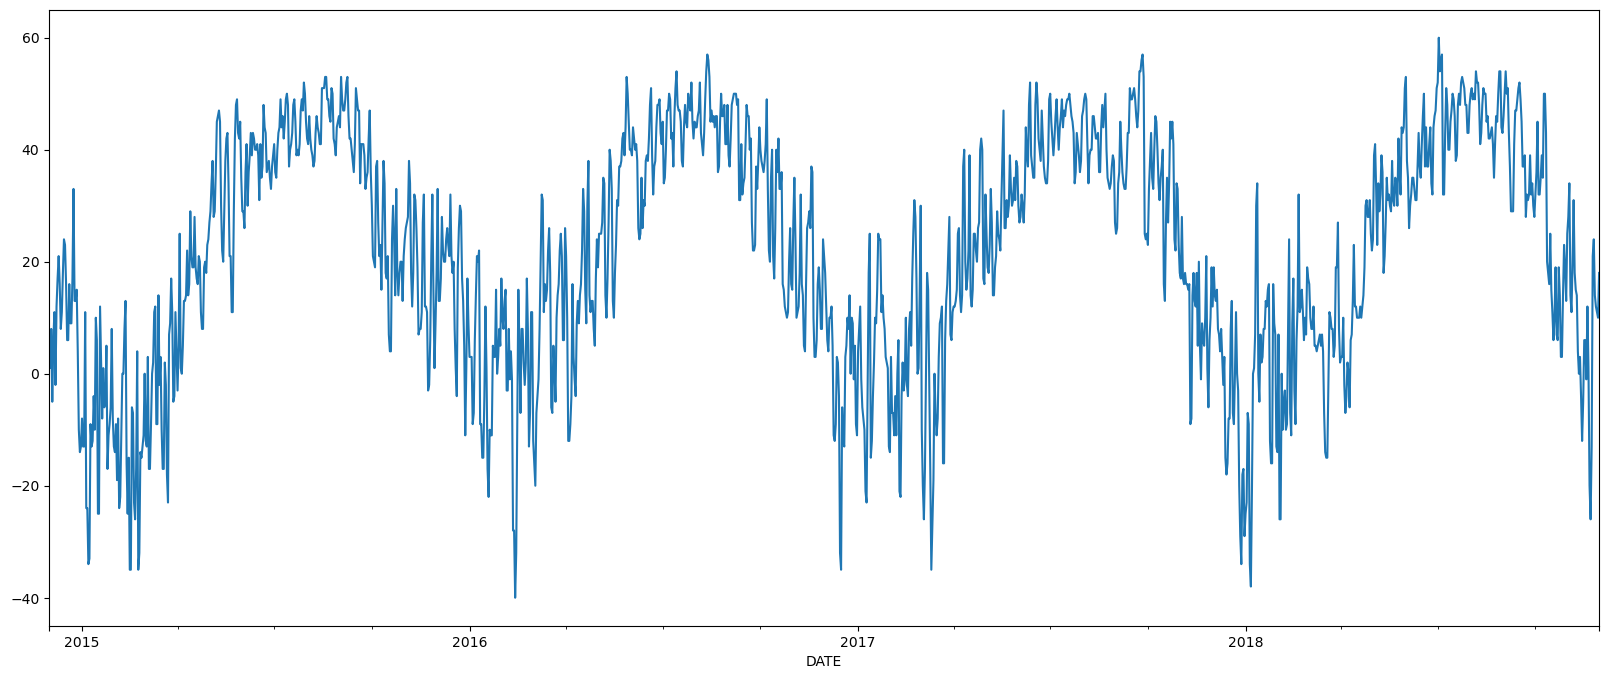

In [3]:
MtWashington_weather.MinTemp.plot(figsize=(20, 8));

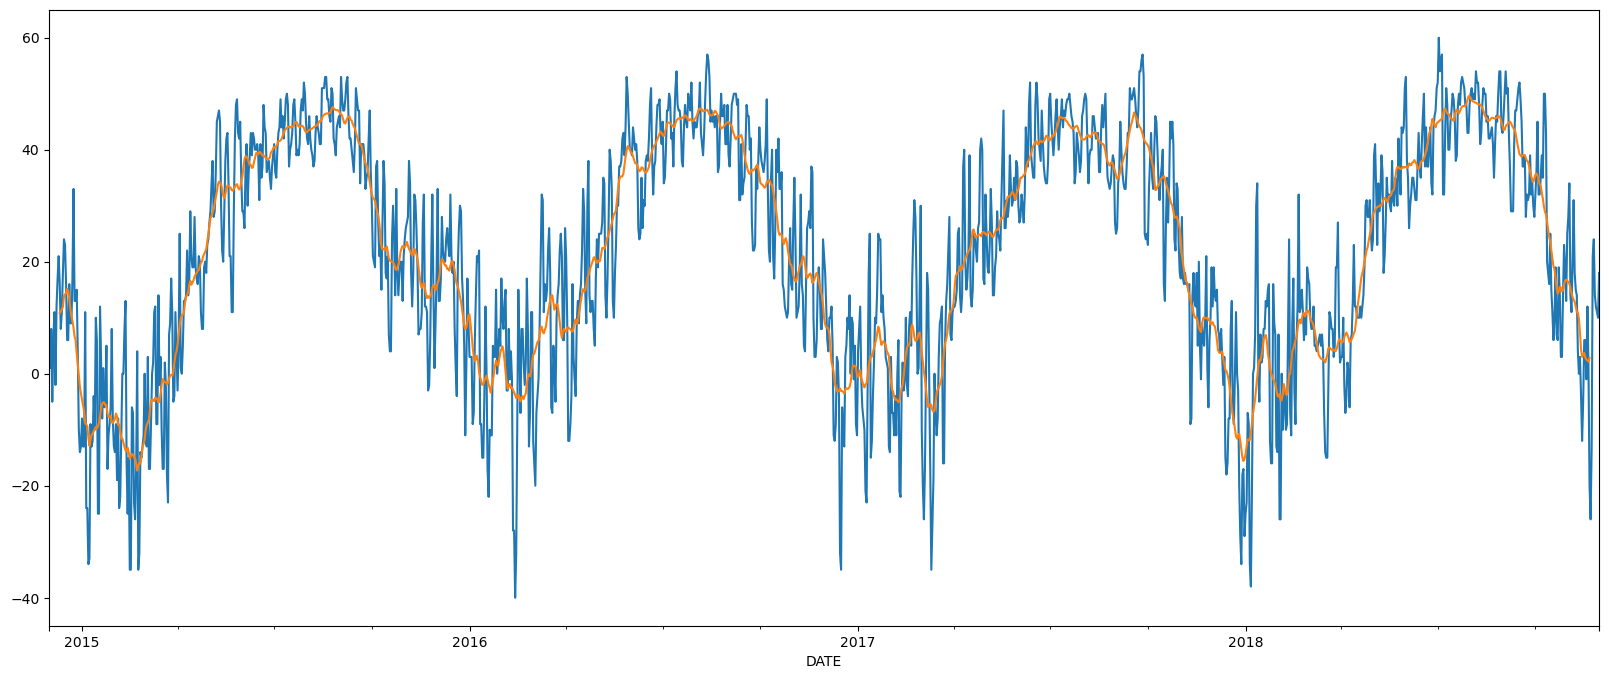

In [4]:
# Moving average smoothing with a = 20
MinTemp_smoothed = MtWashington_weather['MinTemp'].rolling(20, center = True).mean()
MtWashington_weather['MinTemp'].plot(figsize=(10, 5));
MinTemp_smoothed.plot(figsize=(20, 8));

The smoothing parameter of 20 does not seem like enough to capture the development of the data, so perhaps we can increase this to 50 and see how it looks. Here, we have a choice as to what parameter to use, and it is more a matter of personal taste, but does not make a huge difference to use 20 or 50. 

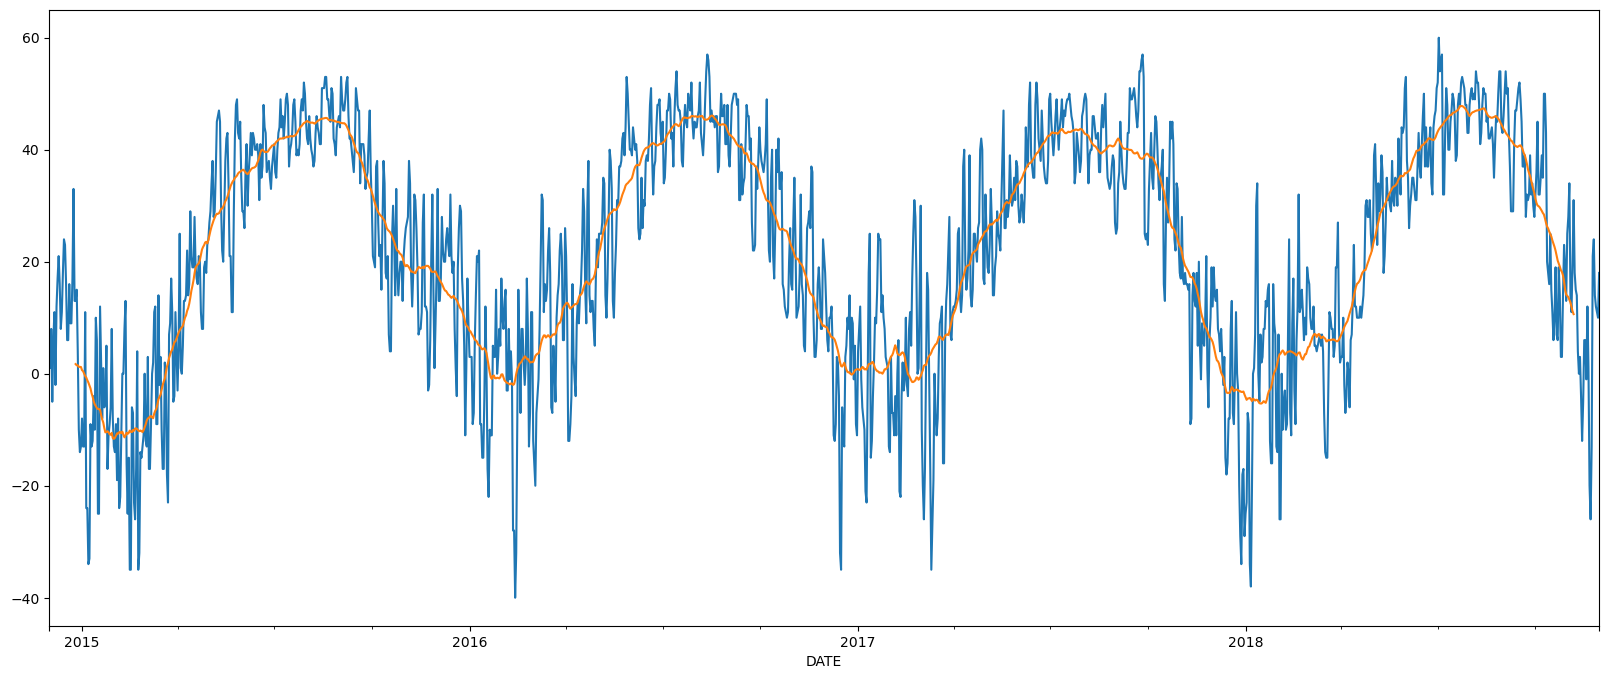

In [5]:
# Moving average smoothing with a = 50
MinTemp_masmoothed = MtWashington_weather['MinTemp'].rolling(50, center = True).mean()
MtWashington_weather['MinTemp'].plot(figsize=(20, 8))
MinTemp_masmoothed.plot(figsize=(20, 8));

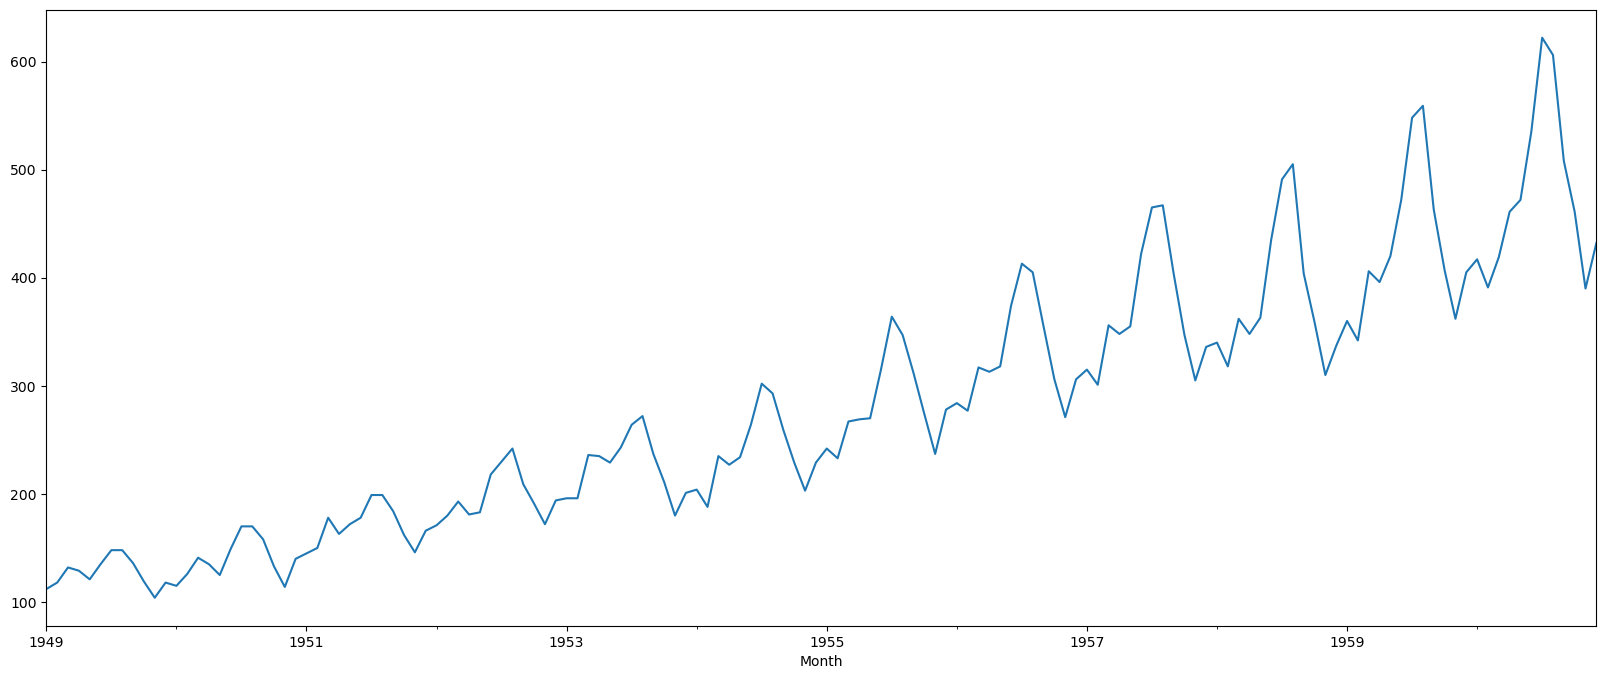

In [6]:
###### Classical Time Series Decomposition
airline_passengers = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)
airline_passengers['Passengers'].plot(figsize=(20, 8));

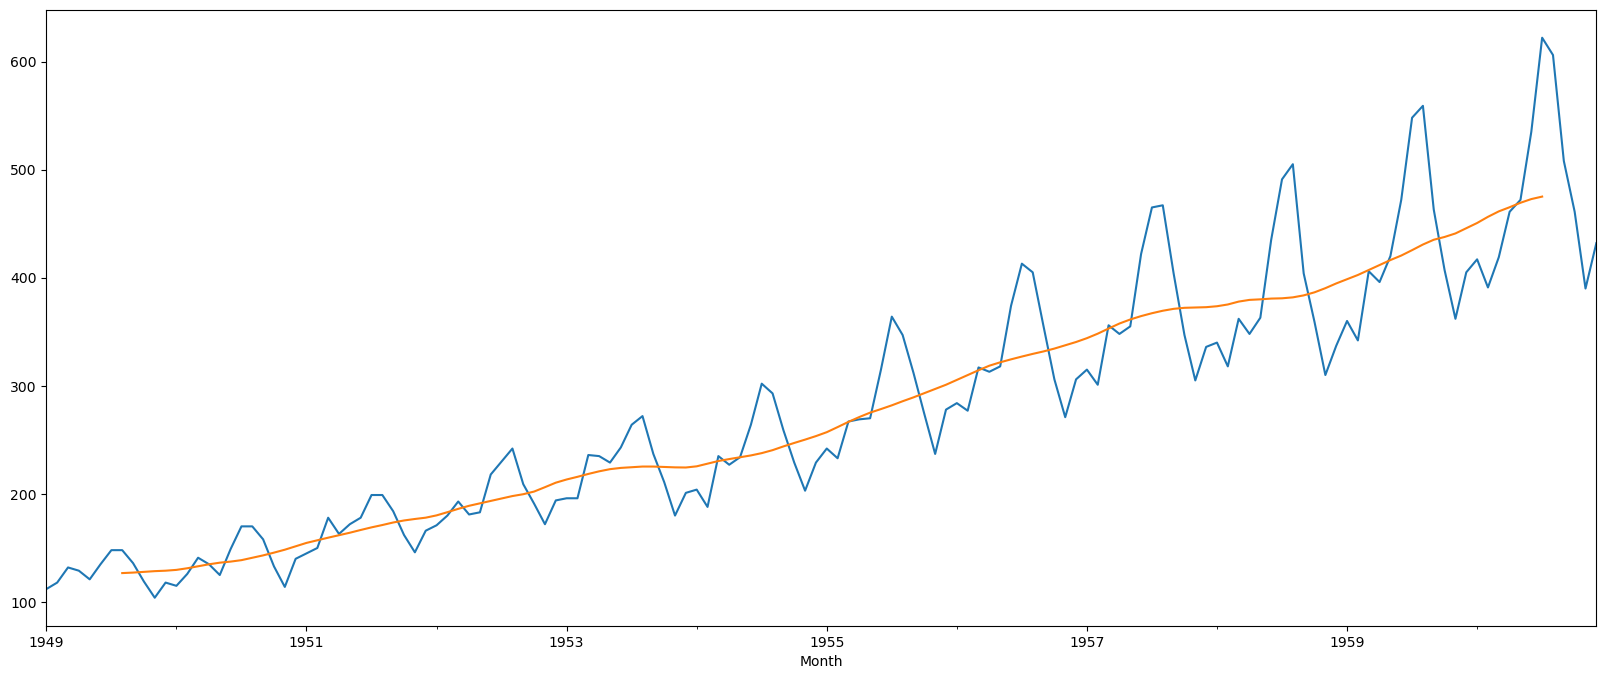

In [7]:
# Moving average smoothing with a = 12
passengers_masmoothed = airline_passengers['Passengers'].rolling(12, center = True).mean()
passengers_masmoothed = passengers_masmoothed.rolling(2, center = True).mean()
airline_passengers['Passengers'].plot(figsize=(20, 8))
passengers_masmoothed.plot(figsize=(20, 8));

12 is an even number, so in order to remove the seasonality, we need to use window size 2. This effectively removes the seasonality.  

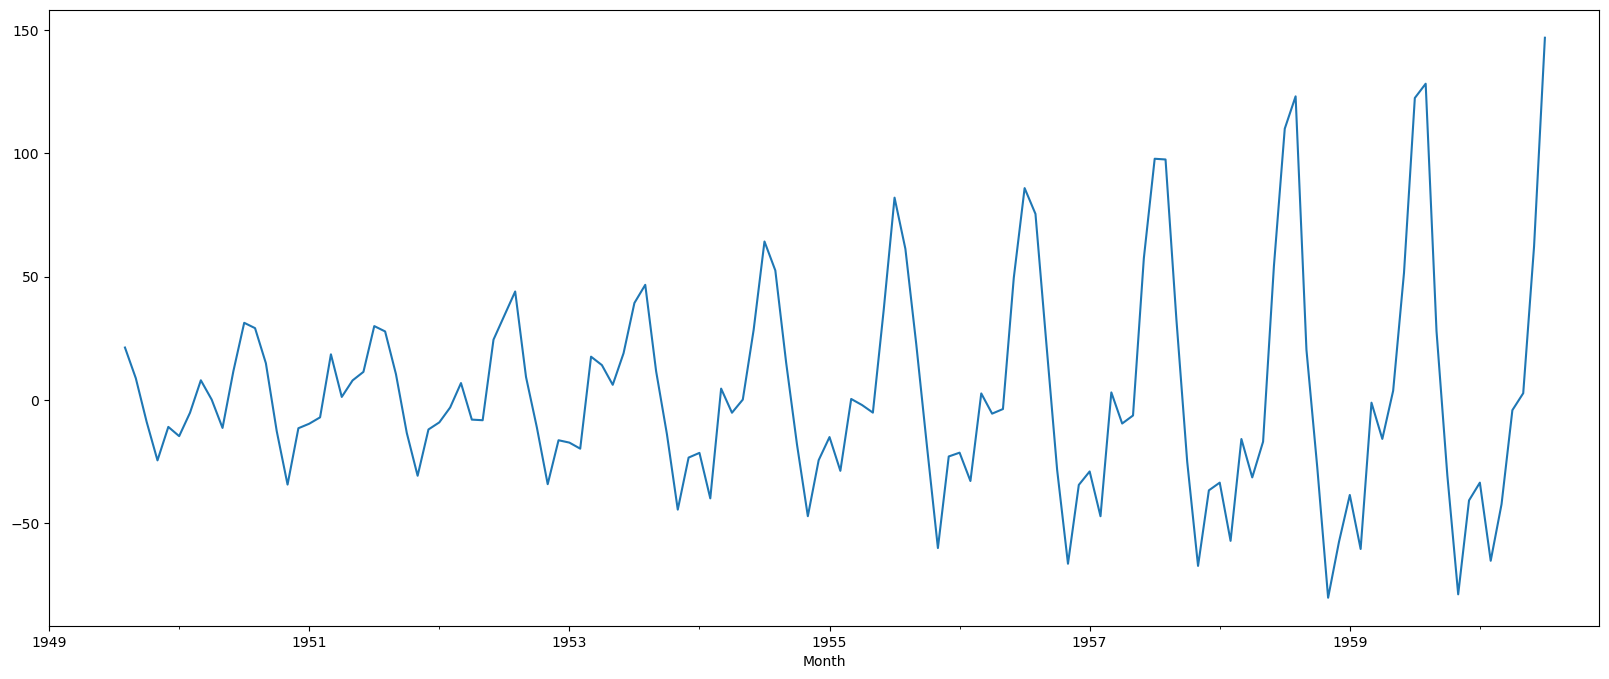

In [8]:
# Additive decomposition 
passengers_detrended_add = airline_passengers['Passengers'] - passengers_masmoothed
passengers_detrended_add.plot(figsize=(20, 8));

This is the detrend series, and you can see that the seasonality increases overtime. So, additive decomposition is clearly not the best choice. 

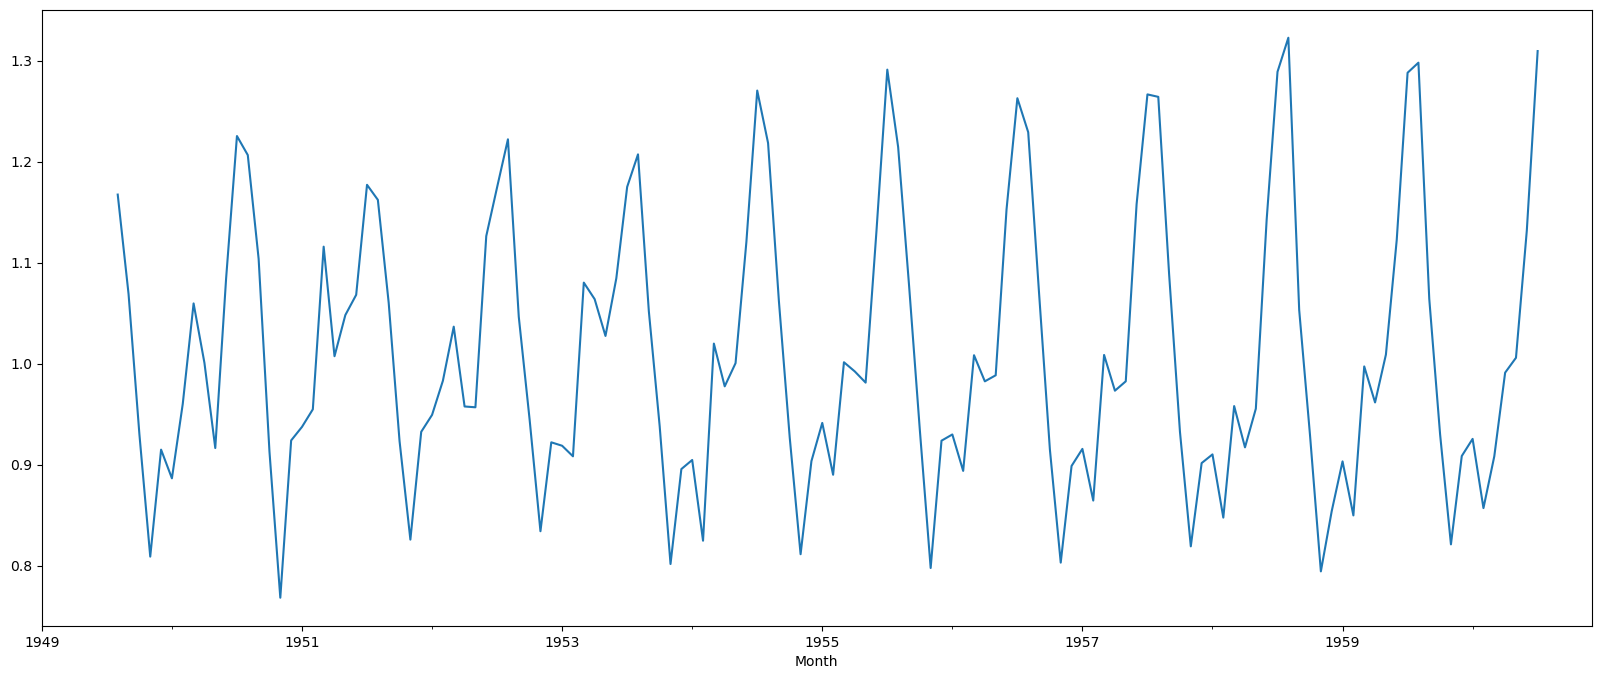

In [9]:
#multiplicative decomposition
passengers_detrended_mult = airline_passengers['Passengers']/passengers_masmoothed
passengers_detrended_mult.plot(figsize=(20, 8));

This looks much better, so now we have a detrended series, where the seasonality does not seem to change too much as compared to the previous plot. 

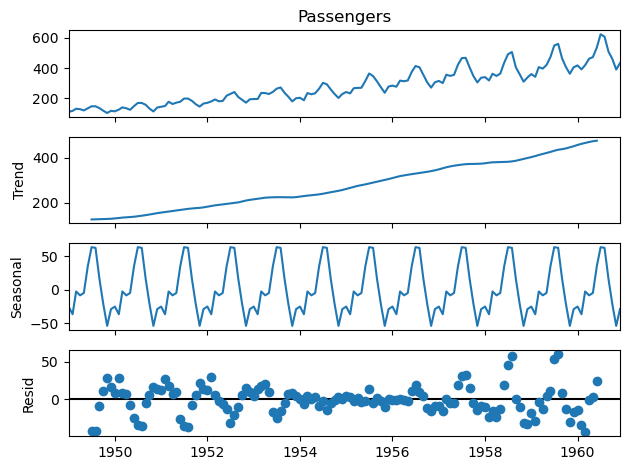

In [10]:
# automatiszed classical additive decomposition
passengers_class_add = seasonal_decompose(airline_passengers['Passengers'], model='additive')
passengers_class_add.plot();

We have classical decomosition here, automated by python. So, we have a lot of very large residuals at tbe beginning as seen in the resid plot, because here the seasonality component overestimates the seasonality, and also underestimates the seasonality. So, it is better to use multiplicative decomposition as seen in the next plots. 

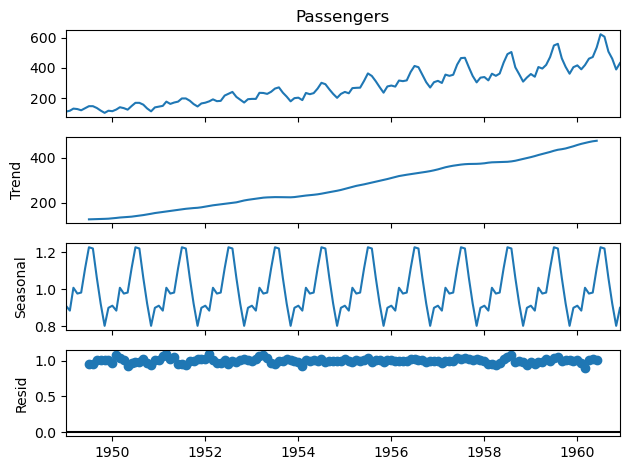

In [11]:
# automatiszed classical multiplicative decomposition
passengers_class_mult = seasonal_decompose(airline_passengers['Passengers'], model='multipliative')
passengers_class_mult.plot();

Here, the resids are much more stable. 

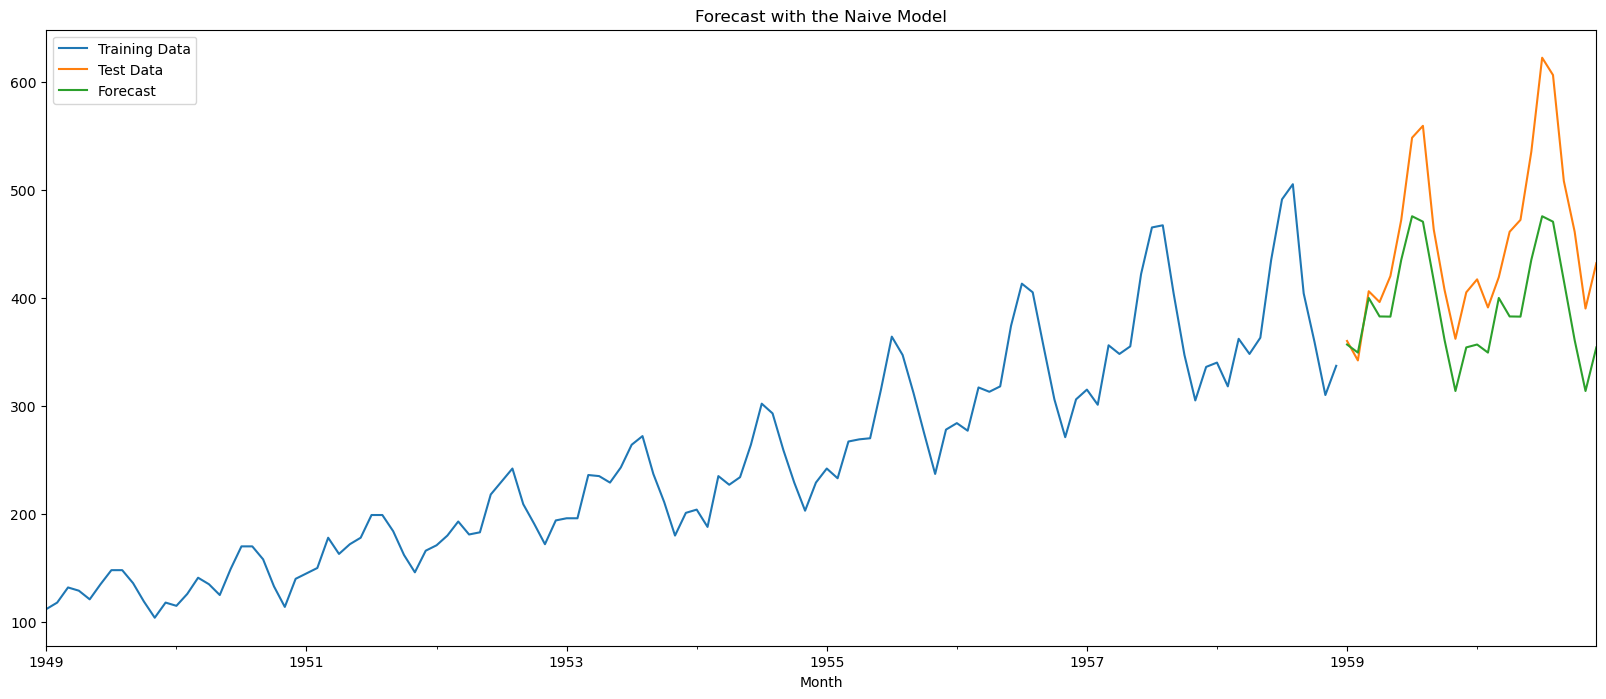

In [12]:
# Forecasting with classical decomposition
# Separate the series into training and test data
train = airline_passengers[0:120] 
test = airline_passengers[120:]

# Decompose the training data via classical decomposition
train_class_mult = seasonal_decompose(train['Passengers'], model='multiplicative')
# Save components as separate variables
train_class_mult  = pd.concat(
    [train_class_mult.seasonal, 
     train_class_mult.trend, 
     train_class_mult.resid, 
     train_class_mult.trend * train_class_mult.resid, 
     train_class_mult.observed], axis=1)
train_class_mult.columns = ['seasonal', 'trend', 'remainders', 'seasonal_adj', 'actual_values']

# Create a forecast dataframe for 24 months with the same columns as train_class_mult and the seasonal component 
class_forecast = train_class_mult.iloc[-24:,:]
# Set the index to that of the test series
class_forecast.index = test.index
class_forecast = class_forecast.drop('actual_values', axis=1)
class_forecast[['trend', 'remainders', 'seasonal_adj']] = np.nan

# Naive forecast for trend and remainders
class_forecast['trend'] = train_class_mult.loc[train_class_mult.index[-7], 'trend']
class_forecast['remainders'] = train_class_mult.loc[train_class_mult.index[-7], 'remainders']
class_forecast['seasonal_adj'] = class_forecast['trend'] * class_forecast['remainders']
# Forecast based on naive forecast of seasonally adjusted component and seasonal component
class_forecast['forecast'] = class_forecast['seasonal_adj'] * class_forecast['seasonal']

plt.figure(figsize=(20, 8))
train["Passengers"].plot(label='Training Data')
test["Passengers"].plot(label='Test Data')
class_forecast['forecast'].plot(label='Forecast')
plt.title("Forecast with the Naive Model")
plt.legend();


Does not look that great because it uses the naive model. Could be a lot better. 

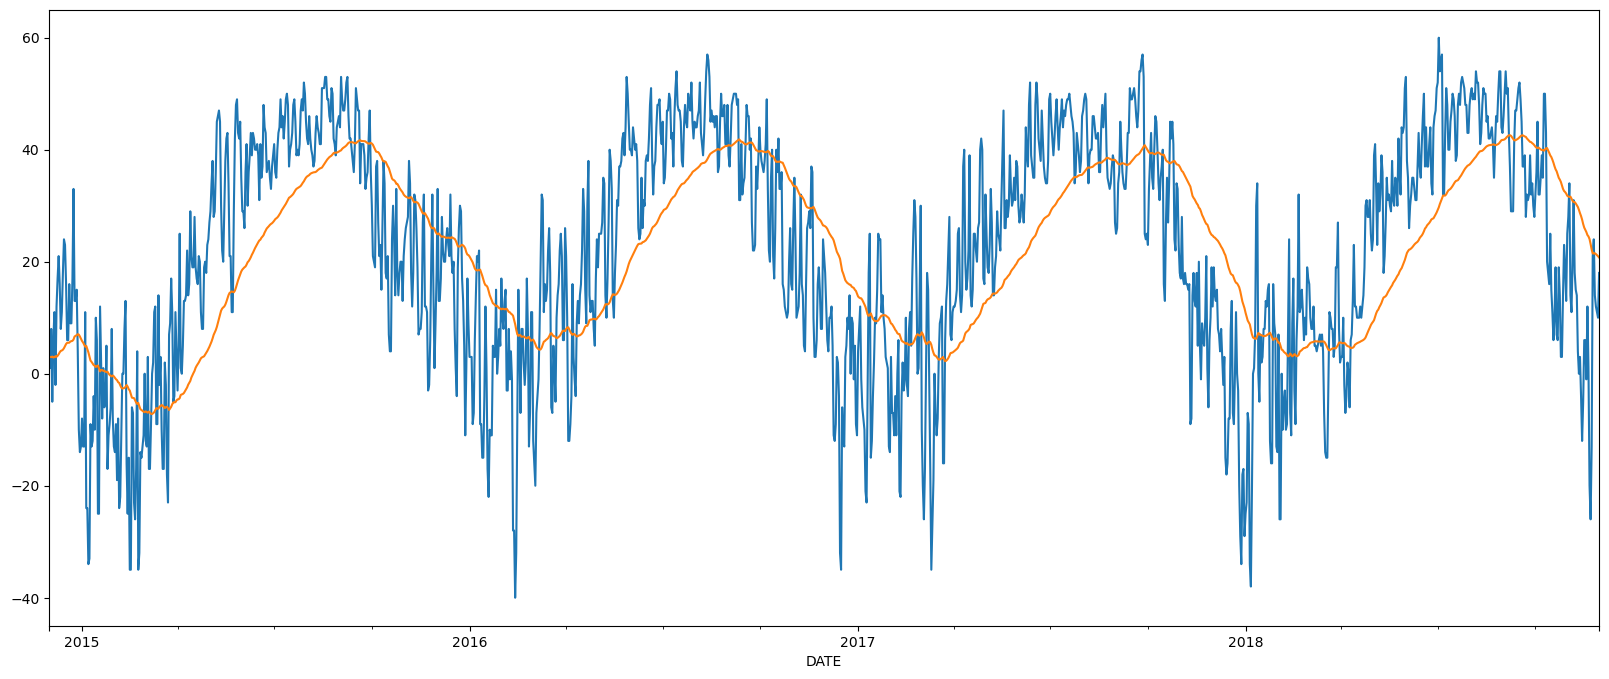

In [13]:
##### Exponential Smoothing
# Simple exponential smoothing with alpha = 0.05
MinTemp_expsmoothed = SimpleExpSmoothing(MtWashington_weather['MinTemp']).fit(smoothing_level = 0.02).fittedvalues
MtWashington_weather['MinTemp'].plot(figsize=(20, 8))
MinTemp_expsmoothed.plot(figsize=(20, 8));


It seems like the forecast line is a bit shifted to the right of the data instead of in the middle of the series. So simple exponential data is not working well with the seasonal data. 

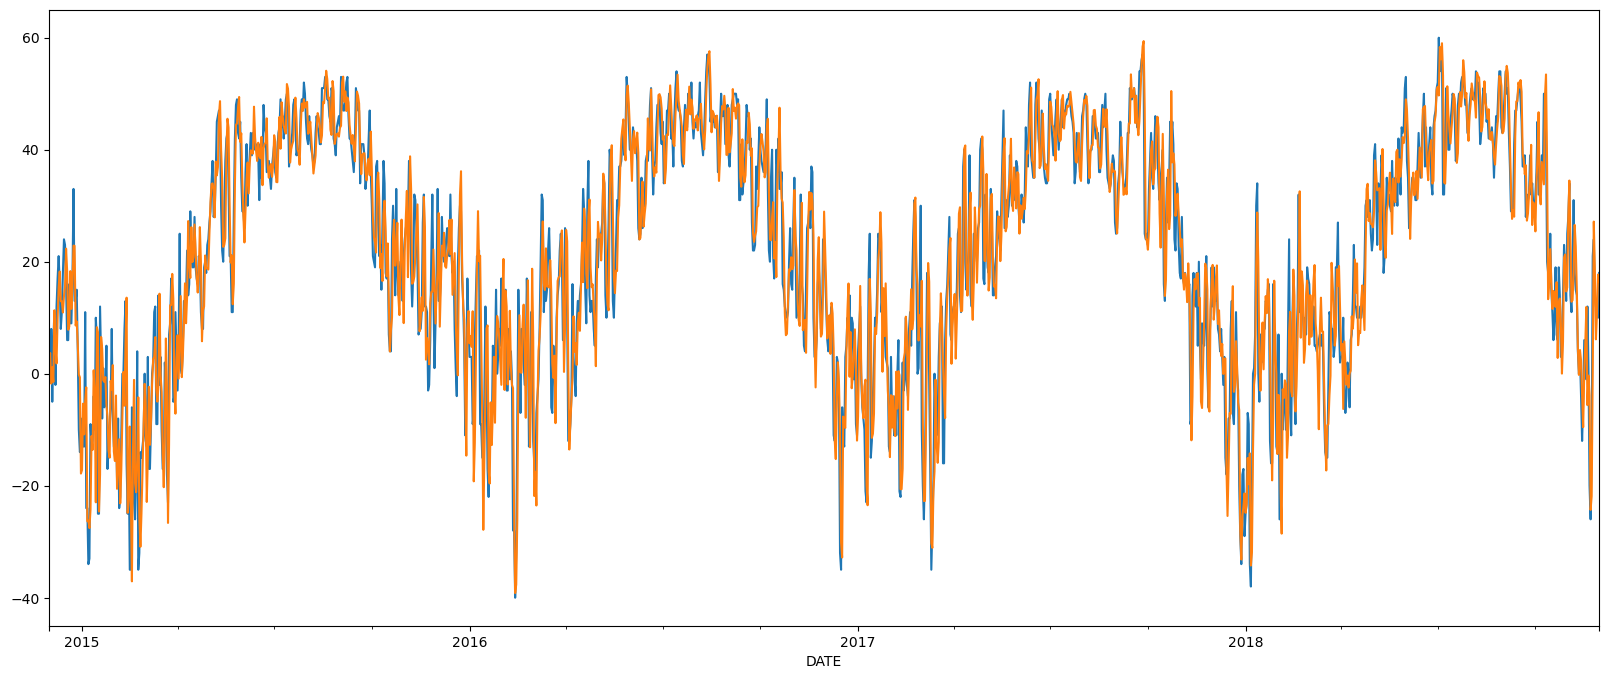

In [14]:
# Holt-Winter's seasonal method with additive trend and seasonality
MtWashington_weather['MinTemp_HoltW'] = ExponentialSmoothing(MtWashington_weather['MinTemp'],  trend = "add",seasonal="add",seasonal_periods=365).fit().fittedvalues
MtWashington_weather['MinTemp'].plot(figsize=(20, 8))
MtWashington_weather['MinTemp_HoltW'].plot(figsize=(20, 8));

With the plot above, we use the exponential smoothing, then we add the trend component, and seasonal component, making this the holt winter's. This works a lot better than the simple expontential smoothing. 

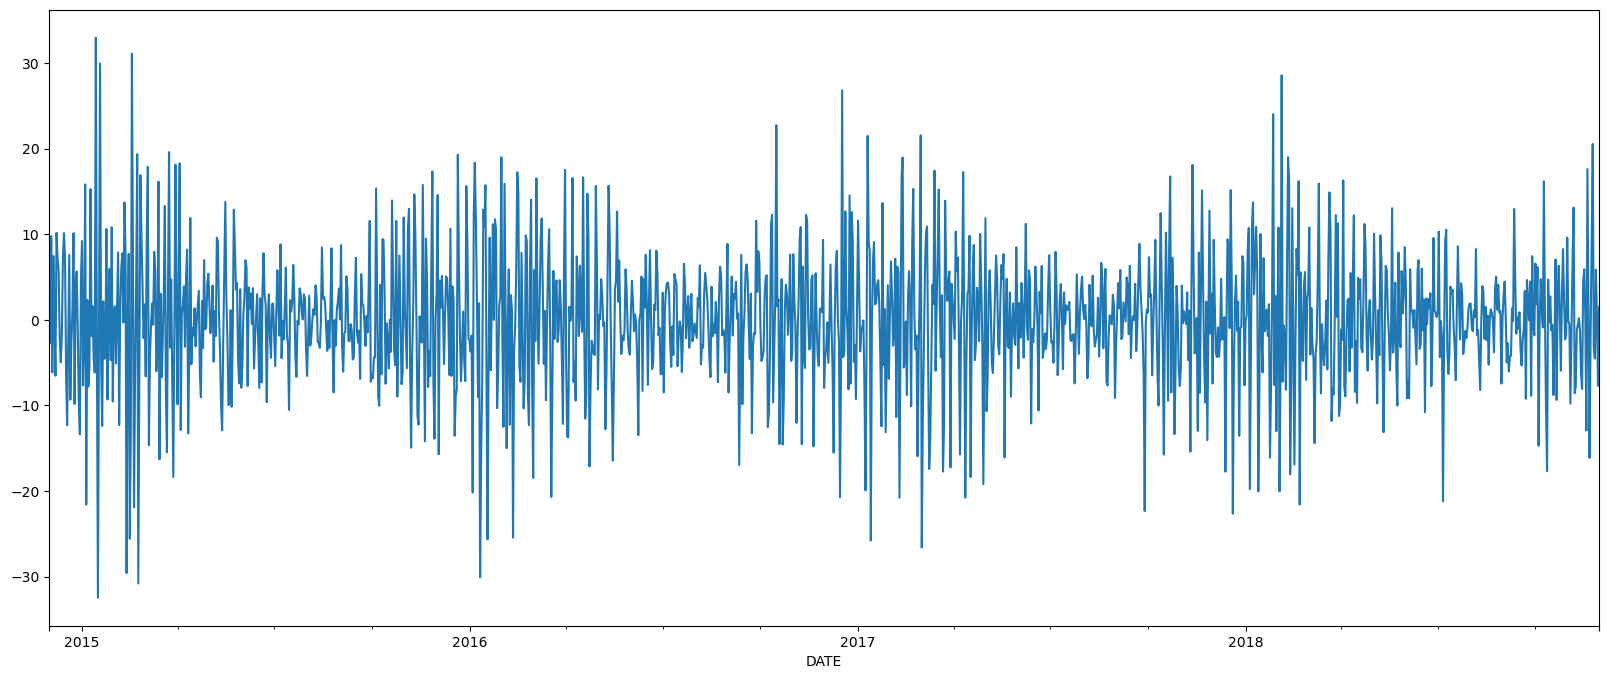

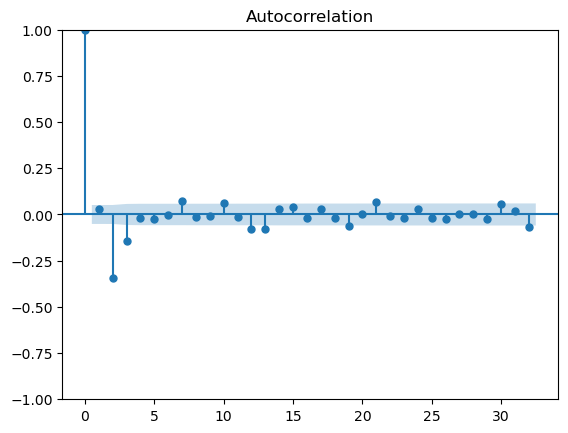

In [15]:
# Residuals Diagnostics
MtWashington_weather["Residual"] = MtWashington_weather['MinTemp'] - MtWashington_weather['MinTemp_HoltW'] # true value minus the forcast
MtWashington_weather["Residual"].plot(figsize=(20, 8));
plot_acf(MtWashington_weather["Residual"]);

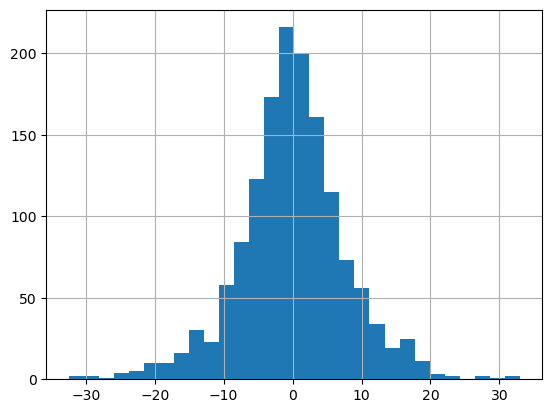

In [16]:
MtWashington_weather["Residual"].hist(bins = 30);

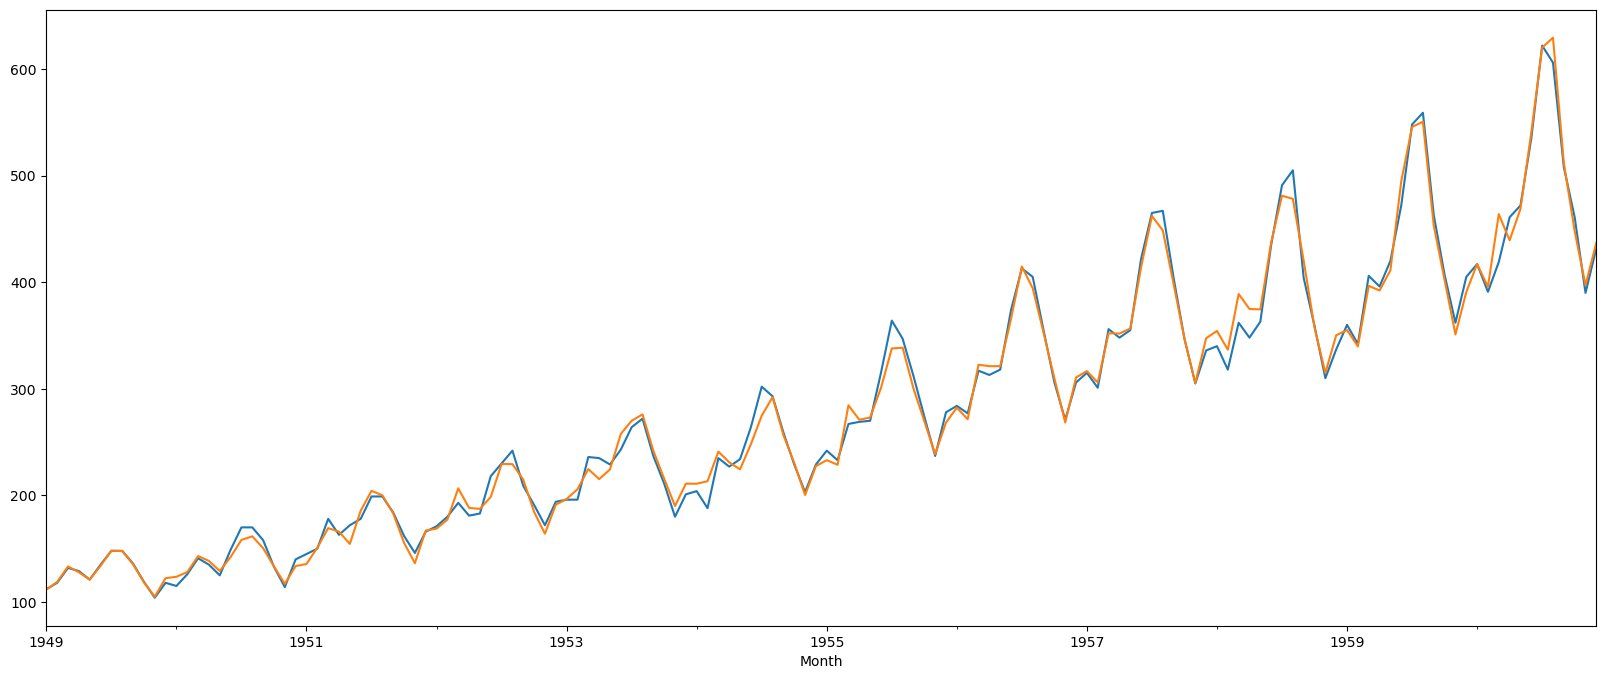

In [17]:
# Holt-Winter's seasonal method with multiplicative trend and seasonality
airline_passengers["Passengers_ExpTrendSeas"] = ExponentialSmoothing(airline_passengers["Passengers"],  trend = "mul",seasonal="mul",seasonal_periods=12).fit().fittedvalues
airline_passengers['Passengers'].plot(figsize=(20, 8))
airline_passengers["Passengers_ExpTrendSeas"].plot(figsize=(20, 8));

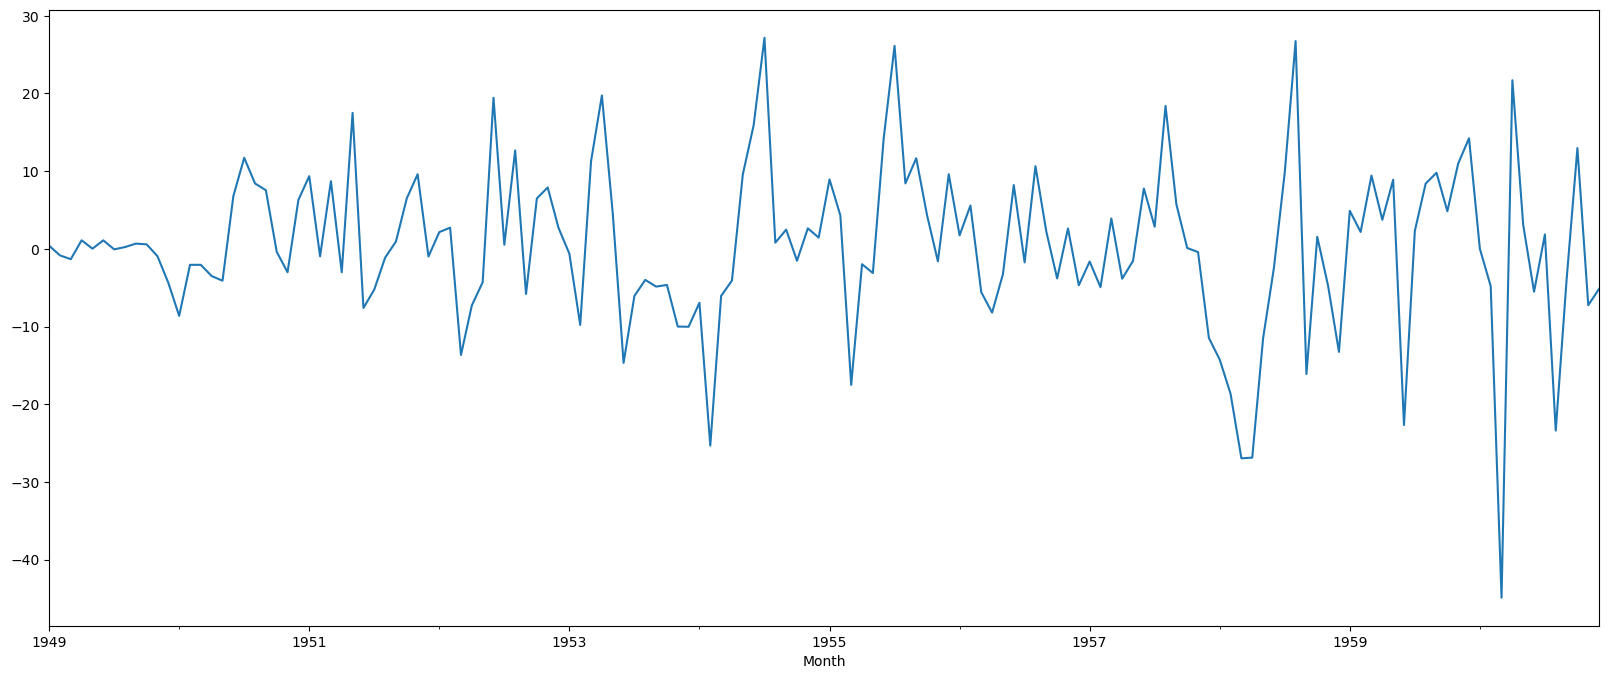

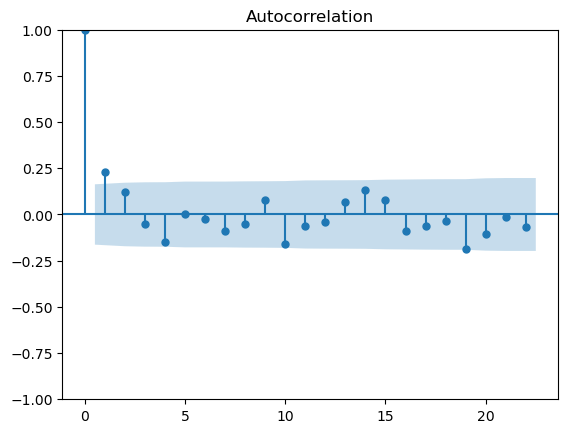

In [18]:
# Residuals
airline_passengers["Residual"] = airline_passengers["Passengers"] - airline_passengers["Passengers_ExpTrendSeas"]
airline_passengers["Residual"].plot(figsize=(20, 8));
plot_acf(airline_passengers["Residual"]);

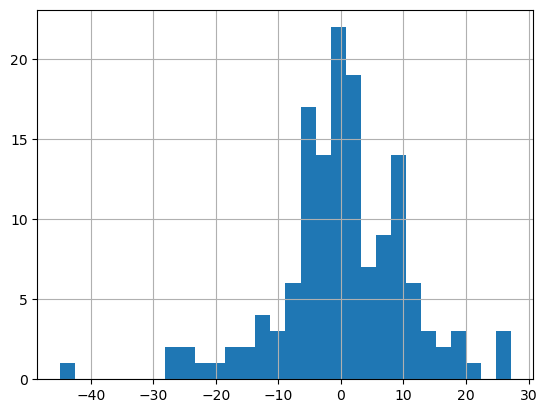

In [19]:
airline_passengers["Residual"].hist(bins = 30);

In [20]:
sm.stats.acorr_ljungbox(airline_passengers["Residual"], boxpierce = True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,7.931637,0.004858,7.768658,0.005316
2,10.104291,0.006396,9.881787,0.007148
3,10.481365,0.014888,10.245948,0.016587
4,13.916052,0.007568,13.539483,0.008920
5,13.918387,0.016136,13.541706,0.018798
6,14.007500,0.029552,13.625937,0.034106
7,15.304701,0.032286,14.843173,0.038063
8,15.730555,0.046403,15.239859,0.054646
9,16.721291,0.053264,16.155951,0.063695
10,20.609287,0.023989,19.724385,0.031970


<Axes: xlabel='Month'>

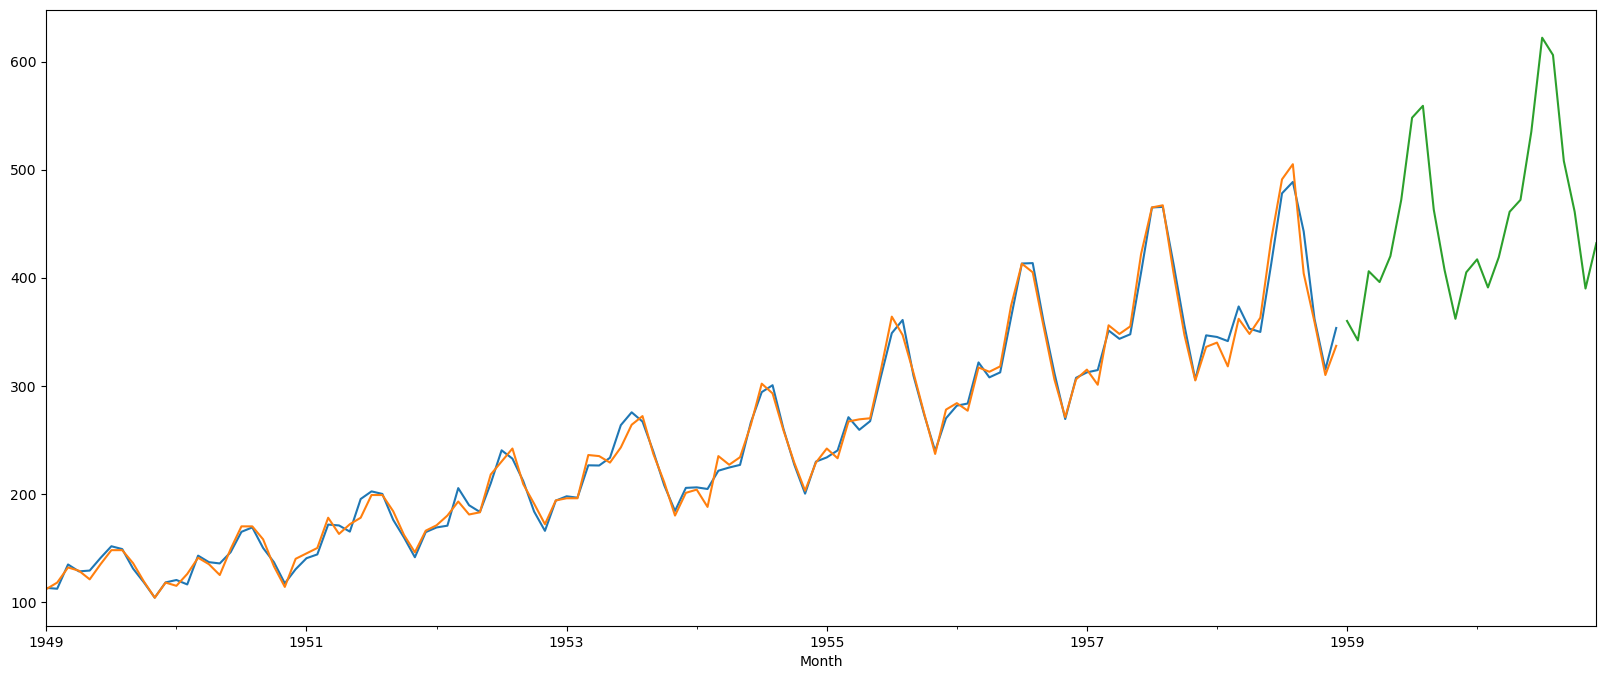

In [21]:
#Forecasting with ETS model
# Separate the series into training and test data
train=airline_passengers[0:120] 
test=airline_passengers[120:]

# Fit the model to the test data
ETSfit = ETSModel(train["Passengers"],error="mul",trend="mul",seasonal="mul",).fit()
train["FittedValues"] = ETSfit.fittedvalues
train["FittedValues"].plot(figsize=(20, 8))
train["Passengers"].plot(figsize=(20, 8))
test["Passengers"].plot(figsize=(20, 8))

In [22]:
# get predictions for test period
pred = ETSfit.get_prediction(start = test.index[0], end = test.index[len(test)-1])
print(pred.summary_frame(alpha=0.05))

                  mean  mean_numerical    pi_lower    pi_upper
1959-01-01  347.575940      347.772317  326.108160  371.732950
1959-02-01  347.763764      347.964404  317.880351  380.395515
1959-03-01  401.597777      401.121587  361.566764  441.503567
1959-04-01  388.673095      388.304503  343.979375  432.356929
1959-05-01  389.465001      389.605487  343.132785  438.419410
1959-06-01  446.358625      446.219168  387.948095  505.036770
1959-07-01  496.405184      495.953777  423.931702  570.931681
1959-08-01  496.982742      496.335443  420.901225  572.239355
1959-09-01  439.060555      439.122945  371.805913  516.231899
1959-10-01  384.720841      384.580959  321.257416  451.670881
1959-11-01  337.033612      336.782841  280.724609  395.935161
1959-12-01  382.899300      382.239684  315.950234  457.440062
1960-01-01  390.533201      390.027983  321.791225  474.460515
1960-02-01  390.744238      390.032118  318.009872  474.727619
1960-03-01  451.231652      450.251671  366.879880  548

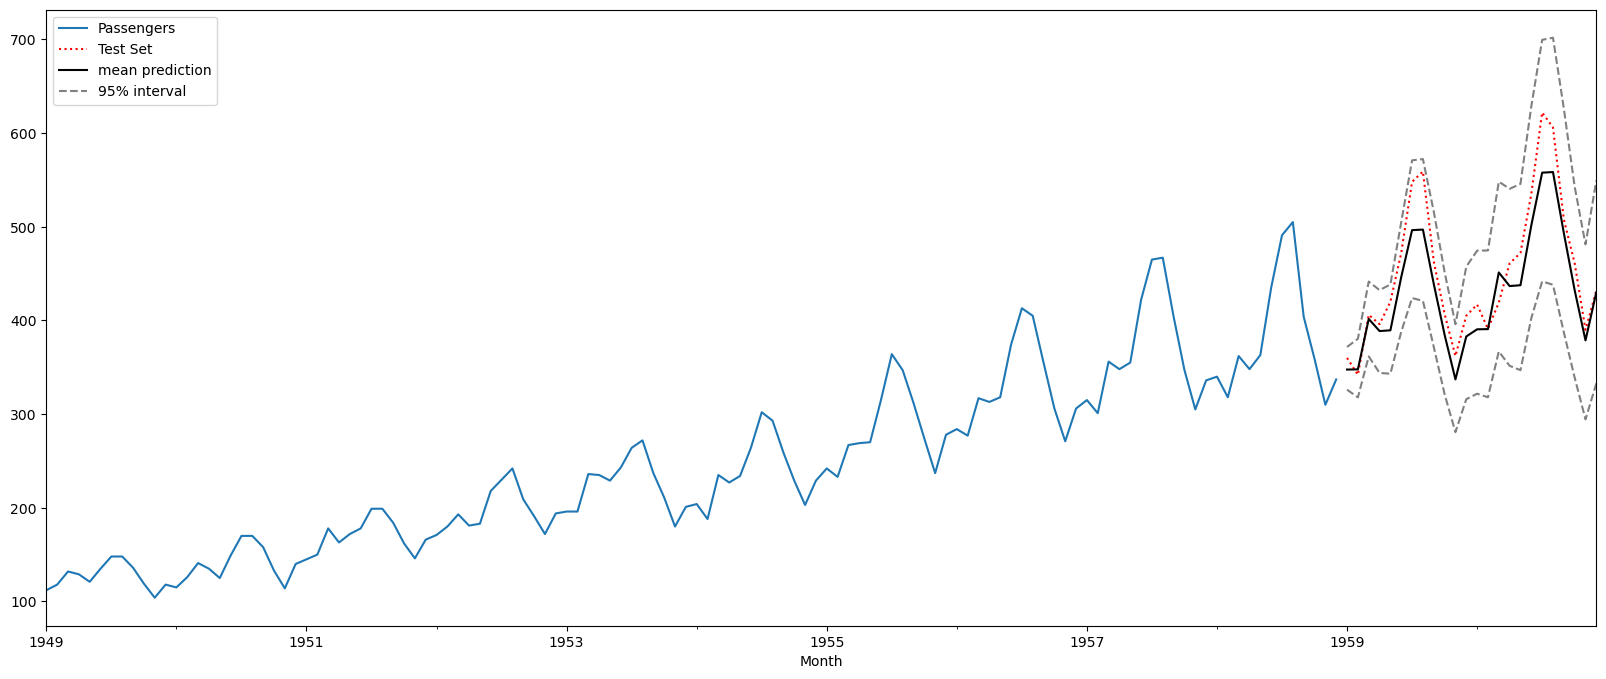

In [23]:

pred_df = pred.summary_frame(alpha=0.05)

train["Passengers"].plot(figsize=(20, 8))
test["Passengers"].plot(figsize=(20, 8), linestyle="dotted", color="red", label="Test Set")
pred_df["mean"].plot(label="mean prediction", color="black")
pred_df["pi_lower"].plot(linestyle="--", color="grey", label="95% interval")
pred_df["pi_upper"].plot(linestyle="--", color="grey", label="_")
plt.legend()

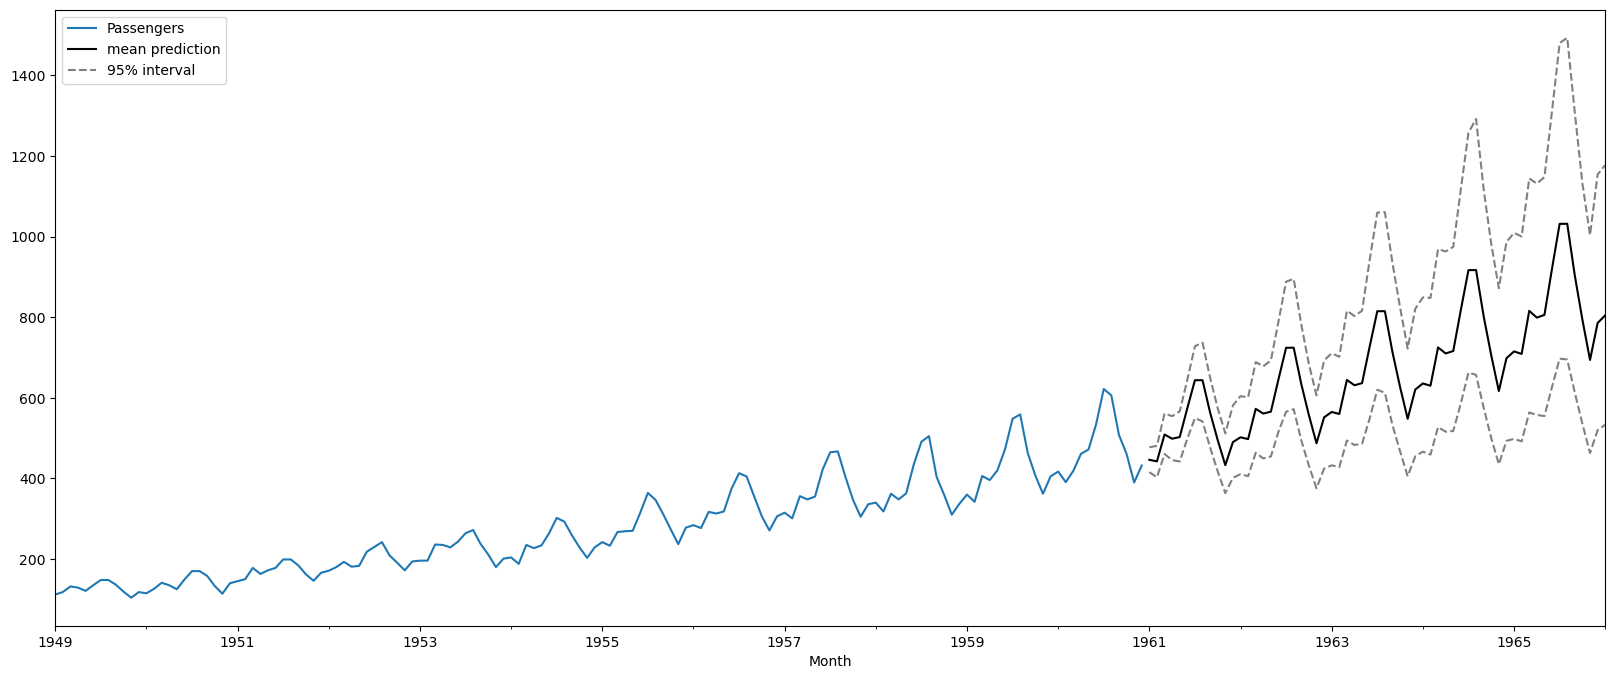

In [24]:
# Forecasting in unknown future
ETSfit = ETSModel(airline_passengers["Passengers"],error="mul",trend="mul",seasonal="mul",).fit()
airline_passengers["FittedValues"] = ETSfit.fittedvalues
prediction = ETSfit.get_prediction(start=144, end=204)

prediction_df = prediction.summary_frame(alpha=0.05)

airline_passengers["Passengers"].plot(figsize=(20, 8))
prediction_df["mean"].plot(label="mean prediction", color="black")
prediction_df["pi_lower"].plot(linestyle="--", color="grey", label="95% interval")
prediction_df["pi_upper"].plot(linestyle="--", color="grey", label="_")
plt.legend()